# システムサイズ vs 自己相関

## import

In [1]:
import numpy as np
import scipy.linalg
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colorbar as colorbars
import matplotlib.gridspec as gridspec
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import datetime
import os
import time
import pathlib
import sys
import uncertainties
import pickle
from uncertainties import ufloat
from tqdm.notebook import tqdm

import made
from made import MADE
import mcmc_function as mcmc
import ising_model as ising
from ising_model import Ising_model
import QAOA_function as qaoa
from QAOA_function import QAOA_ansatz

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['mathtext.fontset'] = 'cm'

seed = None
random.seed(seed)
rng = np.random.default_rng(seed)
#generator = torch.Generator().manual_seed(seed)

## 実験コード

### 初期定数

In [16]:
# QAOA
n_layers = 5
qaoa_init_para = [0.2705, -0.5899, 0.4803, -0.4492, 0.5074, -0.3559, 0.5646, -0.2643, 0.6397, -0.1291] #文献におけるSKmodelに対するQAOA(p=5)の固定角
qaoa_method = "BFGS"
qaoa_options = {"disp": False, "maxiter": 200, "gtol": 1e-6}

# MADE
n_train = 1000
n_test = int(n_train * 0.25)
hidden_layers = 2
batchsize = 8
lr = 0.005
n_epochs = 30

# mcmc
beta = 5.0
n_chain = 10
n_step = 1000
lag = 500
th = 0.05

# instance source
source_dir_name = 'data/instance_set_2024-0614-1705-31'
n_spin_min = 5
n_spin_max = 9

### 関数定義

In [3]:
def mcmc_energy_autocorrelation(spin_history, instance, lag):
	energy_history = np.array([[ising.spin_energy(spin_history[i,j], instance) for j in range(spin_history.shape[1])] for i in range(spin_history.shape[0])])
	energy_mean = np.tile(np.average(energy_history, axis=1).reshape((energy_history.shape[0],1)), (1,spin_history.shape[1]))
	energy_acf = np.zeros((spin_history.shape[0], lag))
    
	for j in range(lag):
		if j == 0:
			energy_acf[:,j] = 1.0
		else:
			n = spin_history.shape[1] - j
			energy_acf[:,j] = np.average((energy_history[:,:n] - energy_mean[:,:n]) * (energy_history[:,-n:] - energy_mean[:,:n]), axis=1)
			energy_acf[:,j] /= np.sqrt(np.average((energy_history[:,:n] - energy_mean[:,:n])**2, axis=1) * np.average((energy_history[:,-n:] - energy_mean[:,:n])**2, axis=1))
	
	return energy_acf

### 計算

In [22]:
n_spin_set = np.arange(n_spin_min, n_spin_max+1)

tau_data = np.zeros((n_spin_set.shape[0], 4, 10))

i = 0
for n_spin in tqdm(n_spin_set):
    # import instance sets
	fname_in = pathlib.Path(source_dir_name).joinpath('{0}_sites_instance_set.pickle'.format(n_spin))
	with open(str(fname_in), 'rb') as f:
		instance_set = pickle.load(f)

	# settings
	hidden_size = int(2 * n_spin)
 
	# calc each instance
	for j in tqdm(range(10), leave=True):
		instance = instance_set[j]
		
		# optimize QAOA ansatz
		prob_hamiltonian = instance.get_hamiltonian()
		mixer_hamiltonian = qaoa.generate_X_mixer(n_spin)
		qaoa_ansatz = QAOA_ansatz(prob_hamiltonian, mixer_hamiltonian, n_layers)

		def qaoa_cost(para):
			return qaoa.cost_QAOA(prob_hamiltonian, qaoa_ansatz, para)

		if qaoa_init_para == None:
			qaoa_para = [rng.uniform(0, 2*np.pi) for i in range(2*n_layers)]
		else:
			qaoa_para = qaoa_init_para

		qaoa_opt = scipy.optimize.minimize(qaoa_cost, qaoa_para, method=qaoa_method, options=qaoa_options)

		# sampling from QAOA distribution
		qaoa_opt_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, qaoa_opt.x, n_train+n_test) # optimize parameter
		qaoa_fix_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, qaoa_init_para, n_train+n_test) # fixed angle

		qaoa_opt_data_nd = np.array([qaoa.number_to_binary(qaoa_opt_data_idx[i], n_spin) for i in range(len(qaoa_opt_data_idx))], dtype='float32') # MADEモデルのコードが重み行列をfloat32で記述しているため、データもfloat32に明示的に指定する！
		qaoa_fix_data_nd = np.array([qaoa.number_to_binary(qaoa_fix_data_idx[i], n_spin) for i in range(len(qaoa_fix_data_idx))], dtype='float32')

		qaoa_opt_data = torch.from_numpy(qaoa_opt_data_nd).to(dtype=torch.float32)
		qaoa_opt_traindata, qaoa_opt_testdata = torch.utils.data.random_split(dataset=qaoa_opt_data, lengths=[n_train, n_test])
		qaoa_fix_data = torch.from_numpy(qaoa_fix_data_nd).to(dtype=torch.float32)
		qaoa_fix_traindata, qaoa_fix_testdata = torch.utils.data.random_split(dataset=qaoa_fix_data, lengths=[n_train, n_test])

		qaoa_opt_testset = torch.utils.data.DataLoader(qaoa_opt_testdata, batch_size=batchsize, shuffle=False)
		qaoa_opt_trainset = torch.utils.data.DataLoader(qaoa_opt_traindata, batch_size=batchsize, shuffle=True)
		qaoa_fix_testset = torch.utils.data.DataLoader(qaoa_fix_testdata, batch_size=batchsize, shuffle=False)
		qaoa_fix_trainset = torch.utils.data.DataLoader(qaoa_fix_traindata, batch_size=batchsize, shuffle=True)

		# learn MADE by QAOA samples
		hidden_list = [hidden_size for i in range(hidden_layers)]

		model_qaoa_opt = MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)
		model_qaoa_fix = MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)

		opt_qaoa_opt = torch.optim.Adam(model_qaoa_opt.parameters(), lr=lr, weight_decay=1e-4)
		scheduler_qaoa_opt = torch.optim.lr_scheduler.StepLR(opt_qaoa_opt, step_size=45, gamma=0.1)
		opt_qaoa_fix = torch.optim.Adam(model_qaoa_fix.parameters(), lr=lr, weight_decay=1e-4)
		scheduler_qaoa_fix = torch.optim.lr_scheduler.StepLR(opt_qaoa_fix, step_size=45, gamma=0.1)

		made.run_train(model_qaoa_opt, qaoa_opt_trainset, qaoa_opt_testset, n_epochs, opt_qaoa_opt, scheduler_qaoa_opt, seed)
		made.run_train(model_qaoa_fix, qaoa_fix_trainset, qaoa_fix_testset, n_epochs, opt_qaoa_fix ,scheduler_qaoa_fix, seed)

		# sampling to models and compute the probability of these outputs
		opt_qaoa_made_outputs_nd = made.predict(model_qaoa_opt, n_step)
		opt_qaoa_made_outputs_spin = np.array([made.binary_to_spin(opt_qaoa_made_outputs_nd[i]) for i in range(opt_qaoa_made_outputs_nd.shape[0])])
		fix_qaoa_made_outputs_nd = made.predict(model_qaoa_fix, n_step)
		fix_qaoa_made_outputs_spin = np.array([made.binary_to_spin(fix_qaoa_made_outputs_nd[i]) for i in range(fix_qaoa_made_outputs_nd.shape[0])])
		opt_qaoa_made_log_prob = made.compute_log_prob(model_qaoa_opt, opt_qaoa_made_outputs_nd)
		fix_qaoa_made_log_prob = made.compute_log_prob(model_qaoa_fix, fix_qaoa_made_outputs_nd)

		# mcmc simulation
		opt_qaoa_made_result = np.zeros((n_chain, n_step+1, n_spin), dtype=np.int8)
		fix_qaoa_made_result = np.zeros((n_chain, n_step+1, n_spin), dtype=np.int8)
		uniform_result = np.zeros((n_chain, n_step+1, n_spin), dtype=np.int8)
		ssf_result = np.zeros((n_chain, n_step+1, n_spin), dtype=np.int8)

		for k in range(n_chain):
			init_spin = ising.number_to_spin(rng.integers(0, 2**n_spin), n_spin)
			opt_qaoa_made_result[k] = mcmc.neural_update_mcmc(init_spin, instance, model_qaoa_opt, opt_qaoa_made_outputs_spin, opt_qaoa_made_log_prob, beta, n_step, rng)[0]
			fix_qaoa_made_result[k] = mcmc.neural_update_mcmc(init_spin, instance, model_qaoa_fix, fix_qaoa_made_outputs_spin, fix_qaoa_made_log_prob, beta, n_step, rng)[0]
			uniform_result[k] = mcmc.uniform_update_mcmc(init_spin, instance, beta, n_step, rng)[0]
			ssf_result[k] = mcmc.ssf_update_mcmc(init_spin, instance, beta, n_step, rng)[0]
   
		# energy autocorrelation
		#energy_acf_history_opt_made = mcmc_energy_autocorrelation(opt_qaoa_made_result[:,1:], instance, lag)
		energy_acf_history_fix_made = mcmc_energy_autocorrelation(fix_qaoa_made_result[:,1:], instance, lag)
		energy_acf_history_uni = mcmc_energy_autocorrelation(uniform_result[:,1:], instance, lag)
		energy_acf_history_ssf = mcmc_energy_autocorrelation(ssf_result[:,1:], instance, lag)
		
		#energy_acf_opt_made_ave = np.average(energy_acf_history_opt_made, axis=0)
		energy_acf_fix_made_ave = np.average(energy_acf_history_fix_made, axis=0)
		energy_acf_uni_ave = np.average(energy_acf_history_uni, axis=0)
		energy_acf_ssf_ave = np.average(energy_acf_history_ssf, axis=0)
  
		# autocorrelation time
		"""
		if np.all(np.abs(energy_acf_opt_made_ave) > th):
			th_opt_made = lag
		else:
			th_opt_made = np.where(np.abs(energy_acf_opt_made_ave) <= th)[0][0]
		"""
		if np.all(np.abs(energy_acf_fix_made_ave) > th):
			th_fix_made = lag
		else:
			th_fix_made = np.where(np.abs(energy_acf_fix_made_ave) <= th)[0][0]
		if np.all(np.abs(energy_acf_uni_ave) > th):
			th_uni = lag
		else:
			th_uni = np.where(np.abs(energy_acf_uni_ave) <= th)[0][0]
		if np.all(np.abs(energy_acf_ssf_ave) > th):
			th_ssf = lag
		else:
			th_ssf = np.where(np.abs(energy_acf_ssf_ave) <= th)[0][0]

		#print(th_opt_made)
		#print(th_fix_made)
		#print(th_uni)
		#print(th_ssf)

		def exp_func_3(x,a):
			return np.exp(-a * x)

		#opt_popt, opt_pcov = curve_fit(exp_func_3, np.arange(th_opt_made), np.abs(energy_acf_opt_made_ave)[0:th_opt_made])
		fix_popt, fix_pcov = curve_fit(exp_func_3, np.arange(th_fix_made), np.abs(energy_acf_fix_made_ave)[0:th_fix_made])
		uni_popt, uni_pcov = curve_fit(exp_func_3, np.arange(th_uni), np.abs(energy_acf_uni_ave)[0:th_uni])
		ssf_popt, ssf_pcov = curve_fit(exp_func_3, np.arange(th_ssf), np.abs(energy_acf_ssf_ave)[0:th_ssf])

		#tau_data[i,0,j] = 1.0 / opt_popt[0]
		tau_data[i,1,j] = 1.0 / fix_popt[0]
		tau_data[i,2,j] = 1.0 / uni_popt[0]
		tau_data[i,3,j] = 1.0 / ssf_popt[0]

	i += 1

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/5z/hnd7blsn33vdfn4r3xgj5_sh0000gn/T/ipykernel_24257/2191330516.py:123: RuntimeWarning: overflow encountered in exp
  return np.exp(-a * x)
/var/folders/5z/hnd7blsn33vdfn4r3xgj5_sh0000gn/T/ipykernel_24257/2788105556.py:12: RuntimeWarning: invalid value encountered in divide
  energy_acf[:,j] /= np.sqrt(np.average((energy_history[:,:n] - energy_mean[:,:n])**2, axis=1) * np.average((energy_history[:,-n:] - energy_mean[:,:n])**2, axis=1))


IndexError: index 0 is out of bounds for axis 0 with size 0

### テスト

In [25]:
n_spin = 5

# import instance sets
fname_in = pathlib.Path(source_dir_name).joinpath('{0}_sites_instance_set.pickle'.format(n_spin))
with open(str(fname_in), 'rb') as f:
	instance_set = pickle.load(f)
# settings
hidden_size = int(2 * n_spin)

instance = instance_set[9]

# optimize QAOA ansatz
prob_hamiltonian = instance.get_hamiltonian()
mixer_hamiltonian = qaoa.generate_X_mixer(n_spin)
qaoa_ansatz = QAOA_ansatz(prob_hamiltonian, mixer_hamiltonian, n_layers)
def qaoa_cost(para):
	return qaoa.cost_QAOA(prob_hamiltonian, qaoa_ansatz, para)
if qaoa_init_para == None:
	qaoa_para = [rng.uniform(0, 2*np.pi) for i in range(2*n_layers)]
else:
	qaoa_para = qaoa_init_para
qaoa_opt = scipy.optimize.minimize(qaoa_cost, qaoa_para, method=qaoa_method, options=qaoa_options)

# sampling from QAOA distribution
qaoa_opt_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, qaoa_opt.x, n_train+n_test) # optimize parameter
qaoa_fix_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, qaoa_init_para, n_train+n_test) # fixed angle
qaoa_opt_data_nd = np.array([qaoa.number_to_binary(qaoa_opt_data_idx[i], n_spin) for i in range(len(qaoa_opt_data_idx))], dtype='float32') # MADEモデルのコードが重み行列をfloat32で記述しているため、データもfloat32に明示的に指定する！
qaoa_fix_data_nd = np.array([qaoa.number_to_binary(qaoa_fix_data_idx[i], n_spin) for i in range(len(qaoa_fix_data_idx))], dtype='float32')
qaoa_opt_data = torch.from_numpy(qaoa_opt_data_nd).to(dtype=torch.float32)
qaoa_opt_traindata, qaoa_opt_testdata = torch.utils.data.random_split(dataset=qaoa_opt_data, lengths=[n_train, n_test])
qaoa_fix_data = torch.from_numpy(qaoa_fix_data_nd).to(dtype=torch.float32)
qaoa_fix_traindata, qaoa_fix_testdata = torch.utils.data.random_split(dataset=qaoa_fix_data, lengths=[n_train, n_test])
qaoa_opt_testset = torch.utils.data.DataLoader(qaoa_opt_testdata, batch_size=batchsize, shuffle=False)
qaoa_opt_trainset = torch.utils.data.DataLoader(qaoa_opt_traindata, batch_size=batchsize, shuffle=True)
qaoa_fix_testset = torch.utils.data.DataLoader(qaoa_fix_testdata, batch_size=batchsize, shuffle=False)
qaoa_fix_trainset = torch.utils.data.DataLoader(qaoa_fix_traindata, batch_size=batchsize, shuffle=True)

# learn MADE by QAOA samples
hidden_list = [hidden_size for i in range(hidden_layers)]
model_qaoa_opt = MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)
model_qaoa_fix = MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)
opt_qaoa_opt = torch.optim.Adam(model_qaoa_opt.parameters(), lr=lr, weight_decay=1e-4)
scheduler_qaoa_opt = torch.optim.lr_scheduler.StepLR(opt_qaoa_opt, step_size=45, gamma=0.1)
opt_qaoa_fix = torch.optim.Adam(model_qaoa_fix.parameters(), lr=lr, weight_decay=1e-4)
scheduler_qaoa_fix = torch.optim.lr_scheduler.StepLR(opt_qaoa_fix, step_size=45, gamma=0.1)
made.run_train(model_qaoa_opt, qaoa_opt_trainset, qaoa_opt_testset, n_epochs, opt_qaoa_opt, scheduler_qaoa_opt, seed)
made.run_train(model_qaoa_fix, qaoa_fix_trainset, qaoa_fix_testset, n_epochs, opt_qaoa_fix ,scheduler_qaoa_fix, seed)
# sampling to models and compute the probability of these outputs
opt_qaoa_made_outputs_nd = made.predict(model_qaoa_opt, n_step)
opt_qaoa_made_outputs_spin = np.array([made.binary_to_spin(opt_qaoa_made_outputs_nd[i]) for i in range(opt_qaoa_made_outputs_nd.shape[0])])
fix_qaoa_made_outputs_nd = made.predict(model_qaoa_fix, n_step)
fix_qaoa_made_outputs_spin = np.array([made.binary_to_spin(fix_qaoa_made_outputs_nd[i]) for i in range(fix_qaoa_made_outputs_nd.shape[0])])
opt_qaoa_made_log_prob = made.compute_log_prob(model_qaoa_opt, opt_qaoa_made_outputs_nd)
fix_qaoa_made_log_prob = made.compute_log_prob(model_qaoa_fix, fix_qaoa_made_outputs_nd)

# mcmc simulation
opt_qaoa_made_result = np.zeros((n_chain, n_step+1, n_spin), dtype=np.int8)
fix_qaoa_made_result = np.zeros((n_chain, n_step+1, n_spin), dtype=np.int8)
uniform_result = np.zeros((n_chain, n_step+1, n_spin), dtype=np.int8)
ssf_result = np.zeros((n_chain, n_step+1, n_spin), dtype=np.int8)

for k in range(n_chain):
	init_spin = ising.number_to_spin(rng.integers(0, 2**n_spin), n_spin)
	opt_qaoa_made_result[k] = mcmc.neural_update_mcmc(init_spin, instance, model_qaoa_opt, opt_qaoa_made_outputs_spin, opt_qaoa_made_log_prob, beta, n_step, rng)[0]
	fix_qaoa_made_result[k] = mcmc.neural_update_mcmc(init_spin, instance, model_qaoa_fix, fix_qaoa_made_outputs_spin, fix_qaoa_made_log_prob, beta, n_step, rng)[0]
	uniform_result[k] = mcmc.uniform_update_mcmc(init_spin, instance, beta, n_step, rng)[0]
	ssf_result[k] = mcmc.ssf_update_mcmc(init_spin, instance, beta, n_step, rng)[0]

# energy autocorrelation
energy_acf_history_opt_made = mcmc_energy_autocorrelation(opt_qaoa_made_result[:,1:], instance, lag)
energy_acf_history_fix_made = mcmc_energy_autocorrelation(fix_qaoa_made_result[:,1:], instance, lag)
energy_acf_history_uni = mcmc_energy_autocorrelation(uniform_result[:,1:], instance, lag)
energy_acf_history_ssf = mcmc_energy_autocorrelation(ssf_result[:,1:], instance, lag)

energy_acf_opt_made_ave = np.average(energy_acf_history_opt_made, axis=0)
energy_acf_fix_made_ave = np.average(energy_acf_history_fix_made, axis=0)
energy_acf_uni_ave = np.average(energy_acf_history_uni, axis=0)
energy_acf_ssf_ave = np.average(energy_acf_history_ssf, axis=0)
#print(energy_acf_history_opt_made[:,:5])
print(energy_acf_history_fix_made[:,:5])

"""
# autocorrelation time
th_opt_made = np.where(np.abs(energy_acf_fix_made_ave) <= th)[0][0]
th_fix_made = np.where(np.abs(energy_acf_fix_made_ave) <= th)[0][0]
th_uni = np.where(np.abs(energy_acf_fix_made_ave) <= th)[0][0]
th_ssf = np.where(np.abs(energy_acf_fix_made_ave) <= th)[0][0]
print(th_opt_made)

def exp_func_3(x,a):
	return np.exp(-a * x)
opt_popt, opt_pcov = curve_fit(exp_func_3, np.arange(th_opt_made), np.abs(energy_acf_opt_made_ave)[0:th_opt_made])
fix_popt, fix_pcov = curve_fit(exp_func_3, np.arange(th_fix_made), np.abs(energy_acf_fix_made_ave)[0:th_fix_made])
uni_popt, uni_pcov = curve_fit(exp_func_3, np.arange(th_uni), np.abs(energy_acf_uni_ave)[0:th_uni])
ssf_popt, ssf_pcov = curve_fit(exp_func_3, np.arange(th_ssf), np.abs(energy_acf_ssf_ave)[0:th_ssf])
tau_data[i,0,j] = 1.0 / opt_popt[0]
tau_data[i,1,j] = 1.0 / fix_popt[0]
tau_data[i,2,j] = 1.0 / uni_popt[0]
tau_data[i,3,j] = 1.0 / ssf_popt[0]
"""

/var/folders/5z/hnd7blsn33vdfn4r3xgj5_sh0000gn/T/ipykernel_24257/2788105556.py:12: RuntimeWarning: invalid value encountered in divide
  energy_acf[:,j] /= np.sqrt(np.average((energy_history[:,:n] - energy_mean[:,:n])**2, axis=1) * np.average((energy_history[:,-n:] - energy_mean[:,:n])**2, axis=1))


[[ 1.          0.49798995  0.2469819  -0.00402816 -0.00403219]
 [ 1.          0.62102829  0.28570446  0.15708172 -0.0059767 ]
 [ 1.          0.4318626   0.21394168 -0.00398097 -0.00398496]
 [ 1.                 nan         nan         nan         nan]
 [ 1.          0.49798995  0.2469819  -0.00348964 -0.00285684]
 [ 1.         -0.00199993 -0.00200193 -0.00200393 -0.00200593]
 [ 1.          0.49489533  0.09694736 -0.00793108 -0.00793905]
 [ 1.          0.66854751  0.40931362  0.26485189  0.19261494]
 [ 1.          0.49899699 -0.00200802 -0.00201003 -0.00201204]
 [ 1.          0.74899498  0.49798794  0.24697888 -0.00403219]]


'\n# autocorrelation time\nth_opt_made = np.where(np.abs(energy_acf_fix_made_ave) <= th)[0][0]\nth_fix_made = np.where(np.abs(energy_acf_fix_made_ave) <= th)[0][0]\nth_uni = np.where(np.abs(energy_acf_fix_made_ave) <= th)[0][0]\nth_ssf = np.where(np.abs(energy_acf_fix_made_ave) <= th)[0][0]\nprint(th_opt_made)\n\ndef exp_func_3(x,a):\n\treturn np.exp(-a * x)\nopt_popt, opt_pcov = curve_fit(exp_func_3, np.arange(th_opt_made), np.abs(energy_acf_opt_made_ave)[0:th_opt_made])\nfix_popt, fix_pcov = curve_fit(exp_func_3, np.arange(th_fix_made), np.abs(energy_acf_fix_made_ave)[0:th_fix_made])\nuni_popt, uni_pcov = curve_fit(exp_func_3, np.arange(th_uni), np.abs(energy_acf_uni_ave)[0:th_uni])\nssf_popt, ssf_pcov = curve_fit(exp_func_3, np.arange(th_ssf), np.abs(energy_acf_ssf_ave)[0:th_ssf])\ntau_data[i,0,j] = 1.0 / opt_popt[0]\ntau_data[i,1,j] = 1.0 / fix_popt[0]\ntau_data[i,2,j] = 1.0 / uni_popt[0]\ntau_data[i,3,j] = 1.0 / ssf_popt[0]\n'

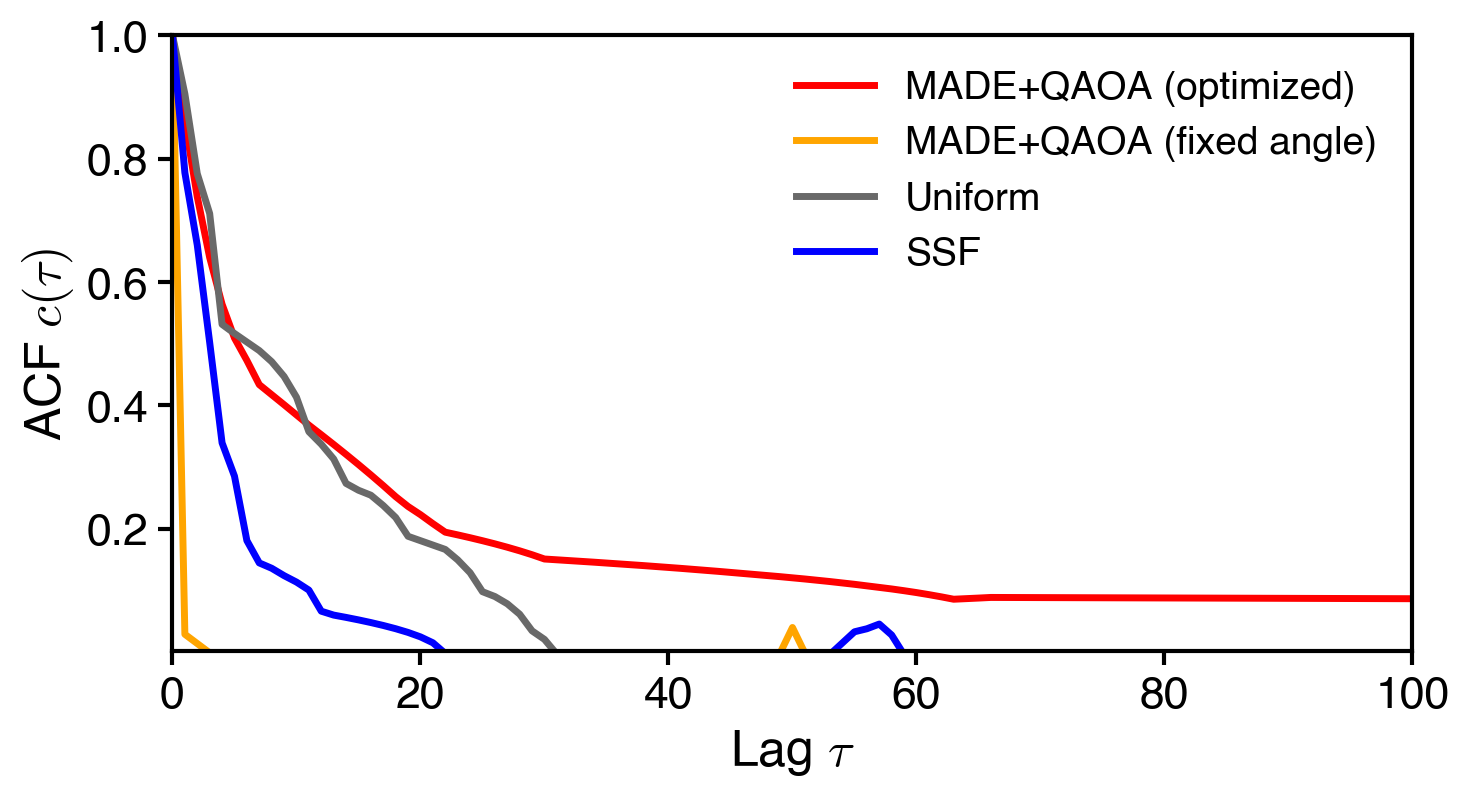

In [19]:
fig4, ax4 = plt.subplots(figsize=(8,4), dpi=200)

capsize = 4
markersize = 7.5
elinewidth = 2.5
capthick = 2.5
linewidth = 2.5
spines = 1.5

ax4.spines["top"].set_linewidth(spines)
ax4.spines["left"].set_linewidth(spines)
ax4.spines["bottom"].set_linewidth(spines)
ax4.spines["right"].set_linewidth(spines)

ax4.plot(np.arange(lag), energy_acf_opt_made_ave, color='red', linewidth=linewidth, label='MADE+QAOA (optimized)')
#ax4.plot(np.arange(lag), opt_fit, color='red', linewidth=linewidth, linestyle='--')
#ax4.fill_between(np.arange(lag), energy_acf_opt_made_ave+energy_acf_opt_made_std, energy_acf_opt_made_ave-energy_acf_opt_made_std, color='red', alpha=0.3, zorder=4)
ax4.plot(np.arange(lag), energy_acf_fix_made_ave, color='orange', linewidth=linewidth, label='MADE+QAOA (fixed angle)')
#ax4.plot(np.arange(lag), fix_fit, color='orange', linewidth=linewidth, linestyle='--')
#ax4.fill_between(np.arange(lag), energy_acf_fix_made_ave+energy_acf_fix_made_std, energy_acf_fix_made_ave-energy_acf_fix_made_std, color='orange', alpha=0.3, zorder=4)
ax4.plot(np.arange(lag), energy_acf_uni_ave, color='dimgrey', linewidth=linewidth, label='Uniform')
#ax4.plot(np.arange(lag), uni_fit, color='dimgrey', linewidth=linewidth, linestyle='--')
#ax4.fill_between(np.arange(lag), energy_acf_uni_ave+energy_acf_uni_std, energy_acf_uni_ave-energy_acf_uni_std, color='dimgrey', alpha=0.3, zorder=4)
ax4.plot(np.arange(lag), energy_acf_ssf_ave, color='blue', linewidth=linewidth, label='SSF')
#ax4.plot(np.arange(lag), ssf_fit, color='blue', linewidth=linewidth, linestyle='--')
#ax4.fill_between(np.arange(lag), energy_acf_ssf_ave+energy_acf_ssf_std, energy_acf_ssf_ave-energy_acf_ssf_std, color='blue', alpha=0.3, zorder=4)

ax4.axhline(0.0, color='black', linestyle='--', linewidth=linewidth)

ax4.set_xlim(0, 100)
#ax4.set_ylim(-0.05,0.05)
ax4.set_ylim(1e-3, 1e0)
#ax4.set_yscale('log')
ax4.set_xlabel(r'Lag $\tau$', fontsize=18)
ax4.set_ylabel(r'ACF $c(\tau)$', fontsize=18)
ax4.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax4.tick_params(axis="x", which='major', width=1.5)
ax4.legend(fontsize=14, loc='upper right', frameon=False)

### うまくいっていないchainについて調査

[[ 1 -1  1 -1 -1]
 [ 1 -1  1 -1 -1]
 [ 1 -1  1 -1 -1]
 ...
 [ 1 -1  1 -1 -1]
 [ 1 -1  1 -1 -1]
 [ 1 -1  1 -1 -1]]
1.232595164407831e-32
1.232595164407831e-32
energy_mean: 0.7637967335561071
energy_history: [0.76379673 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673
 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673
 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673
 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673
 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673
 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673
 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673
 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673
 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673
 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673
 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673
 0.76379673 0.76379673 0.76379673 0.76379673 0.76379673 0

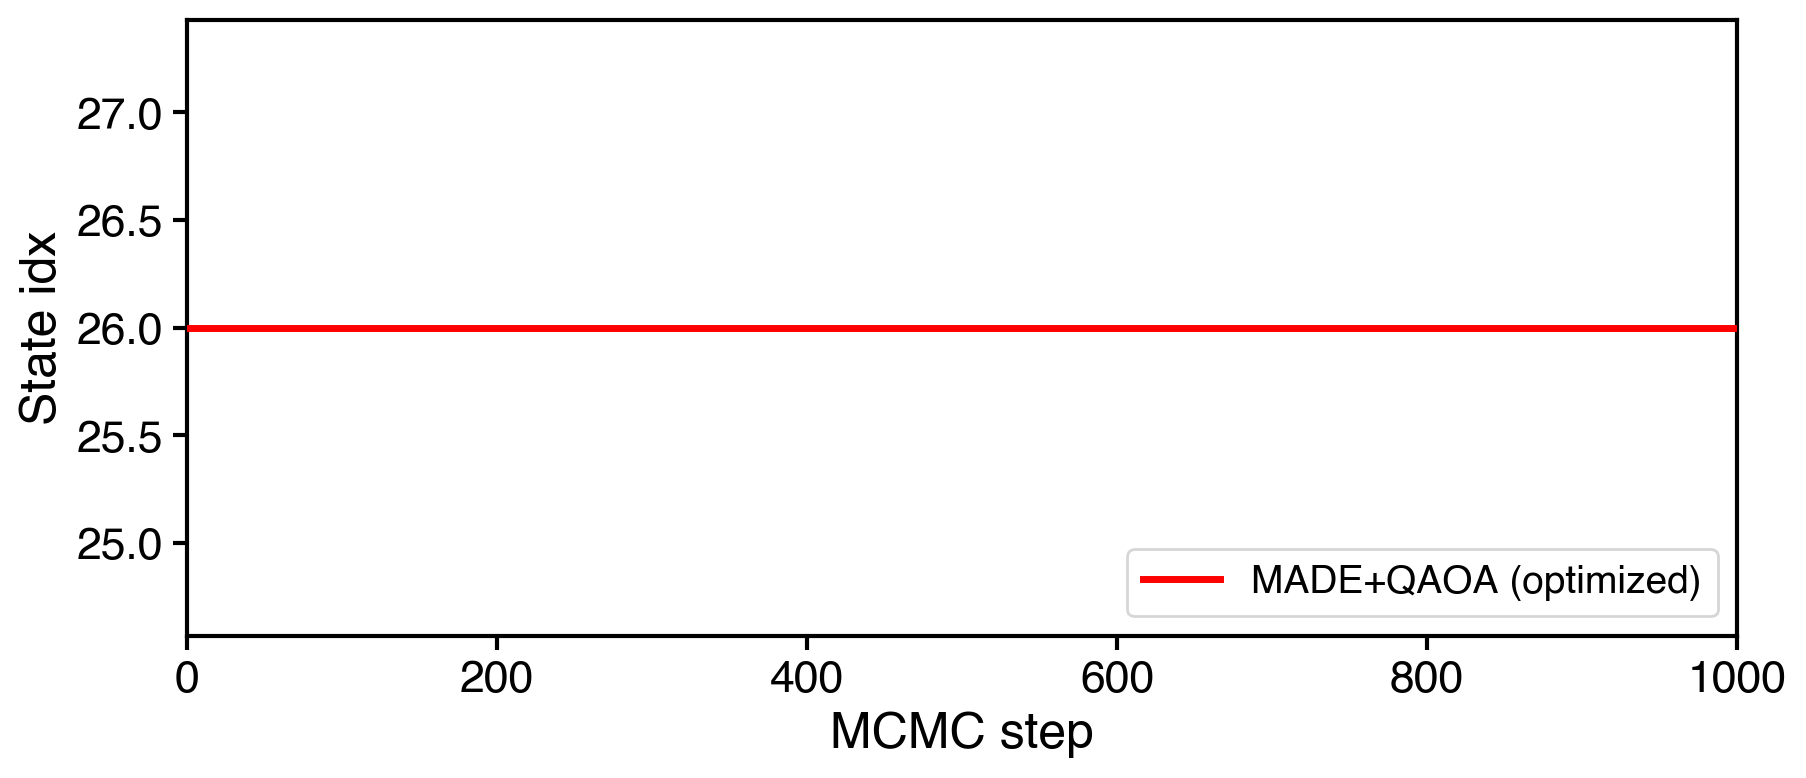

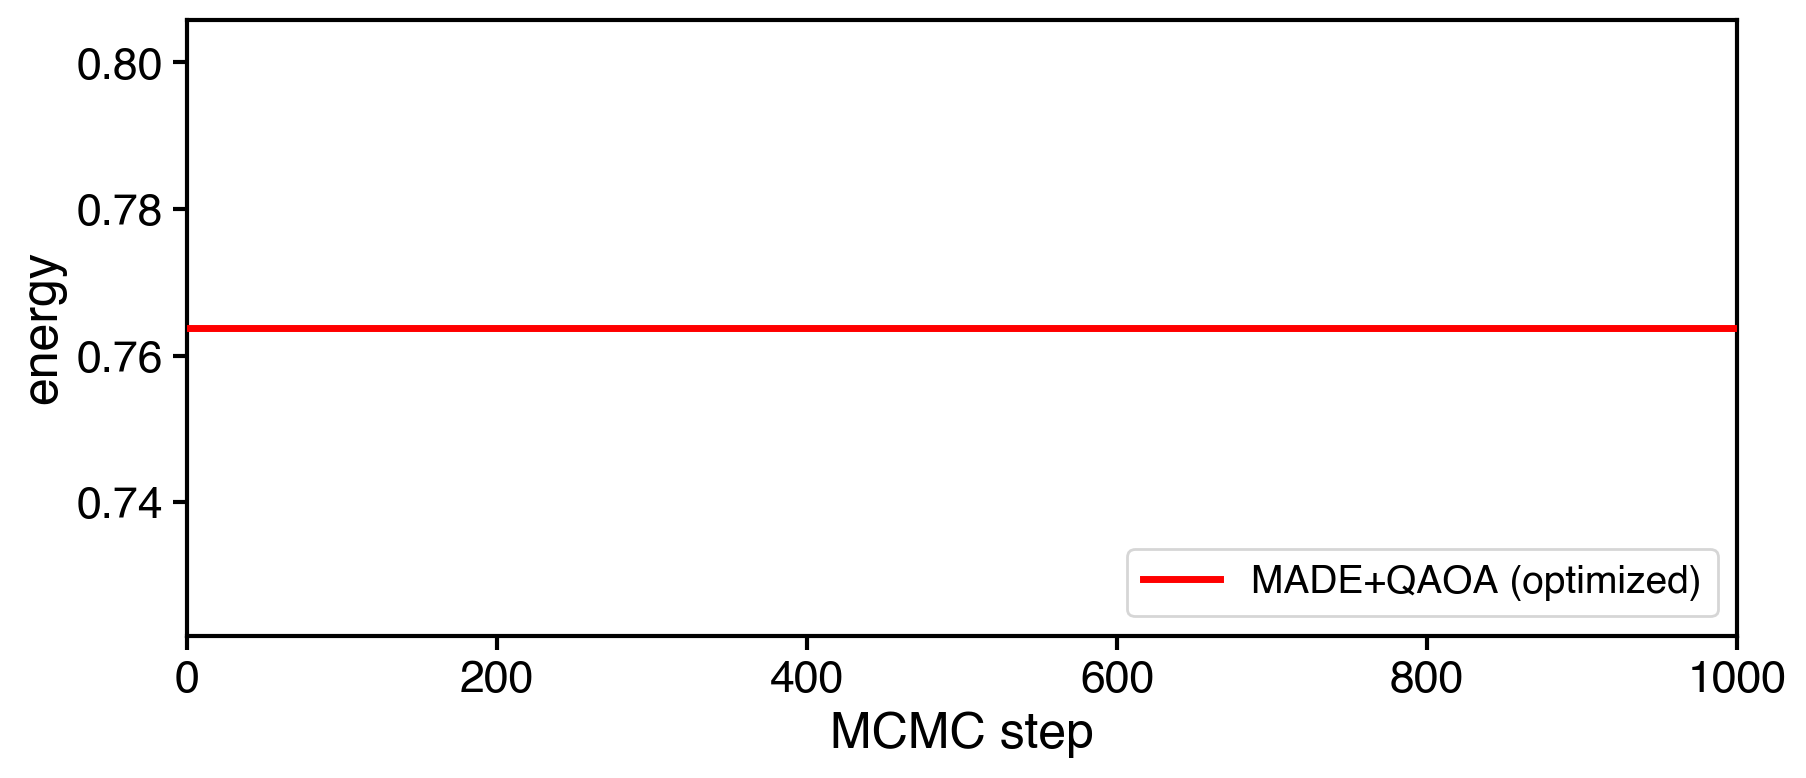

In [21]:
idx = 5
print(opt_qaoa_made_result[idx])

opt_state_hist = np.array([ising.spin_to_number(opt_qaoa_made_result[idx,i]) for i in range(n_step+1)])
opt_energy_hist = np.array([ising.spin_energy(opt_qaoa_made_result[idx,i], instance) for i in range(n_step+1)])

fig3_1, ax3_1 = plt.subplots(figsize=(10,4), dpi=200)

ax3_1.spines["top"].set_linewidth(spines)
ax3_1.spines["left"].set_linewidth(spines)
ax3_1.spines["bottom"].set_linewidth(spines)
ax3_1.spines["right"].set_linewidth(spines)

ax3_1.plot(np.arange(n_step+1), opt_state_hist, color='red', linewidth=linewidth, label='MADE+QAOA (optimized)', zorder=5)

ax3_1.set_xlim(0, n_step)
ax3_1.set_xlabel('MCMC step', fontsize=18)
ax3_1.set_ylabel('State idx', fontsize=18)
ax3_1.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax3_1.tick_params(axis="x", which='major', width=1.5)
ax3_1.legend(fontsize=14, loc='lower right', frameon=True)

fig3_2, ax3_2 = plt.subplots(figsize=(10,4), dpi=200)

ax3_2.spines["top"].set_linewidth(spines)
ax3_2.spines["left"].set_linewidth(spines)
ax3_2.spines["bottom"].set_linewidth(spines)
ax3_2.spines["right"].set_linewidth(spines)

ax3_2.plot(np.arange(n_step+1), opt_energy_hist, color='red', linewidth=linewidth, label='MADE+QAOA (optimized)', zorder=5)

ax3_2.set_xlim(0, n_step)
ax3_2.set_xlabel('MCMC step', fontsize=18)
ax3_2.set_ylabel('energy', fontsize=18)
ax3_2.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax3_2.tick_params(axis="x", which='major', width=1.5)
ax3_2.legend(fontsize=14, loc='lower right', frameon=True)

energy_history = np.array([[ising.spin_energy(opt_qaoa_made_result[i,j], instance) for j in range(opt_qaoa_made_result.shape[1])] for i in range(opt_qaoa_made_result.shape[0])])
energy_mean = np.tile(np.average(energy_history, axis=1).reshape((energy_history.shape[0],1)), (1,opt_qaoa_made_result.shape[1]))
energy_acf = np.zeros((opt_qaoa_made_result.shape[0], lag))

for j in range(lag):
	if j == 0:
		energy_acf[:,j] = 1.0
	else:
		n = opt_qaoa_made_result.shape[1] - j
		print(np.average((energy_history[idx,:n] - energy_mean[idx,:n]) * (energy_history[idx,-n:] - energy_mean[idx,:n])))
		print(np.sqrt(np.average((energy_history[idx,:n] - energy_mean[idx,:n])**2) * np.average((energy_history[idx,-n:] - energy_mean[idx,:n])**2)))
		print('energy_mean: {0}'.format(energy_mean[idx,0]))
		print('energy_history: {0}'.format(energy_history[idx,:n]))
		print('---')